In [1]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model

In [2]:
df = pd.read_csv("data_effnet/character.csv")


,class index,filepaths,labels,data set
0,0,train/savory/0001.jpg,savory,train
1,0,train/savory/0002.jpg,savory,train
2,0,train/savory/0003.jpg,savory,train
3,0,train/savory/0004.jpg,savory,train
4,0,train/savory/0005.jpg,savory,train
...,...,...,...,...
12415,1,valid/unsavory/296.jpg,unsavory,valid
12416,1,valid/unsavory/297.jpg,unsavory,valid
12417,1,valid/unsavory/298.jpg,unsavory,valid
12418,1,valid/unsavory/299.jpg,unsavory,valid


In [3]:
datasets = df.groupby("data set")
train_df = datasets.get_group("train")
test_df = datasets.get_group("test")
valid_df = datasets.get_group("valid")

In [5]:
train_df["filepaths"] = train_df["filepaths"].apply(lambda x: os.path.join("data_effnet", x))
test_df["filepaths"] = test_df["filepaths"].apply(lambda x: os.path.join("data_effnet", x))
valid_df["filepaths"] = valid_df["filepaths"].apply(lambda x: os.path.join("data_effnet", x))

<ipython-input-5-6bcd6c0b8076>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["filepaths"] = train_df["filepaths"].apply(lambda x: os.path.join("data_effnet", x))
<ipython-input-5-6bcd6c0b8076>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["filepaths"] = test_df["filepaths"].apply(lambda x: os.path.join("data_effnet", x))
<ipython-input-5-6bcd6c0b8076>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [6]:
train_df

,class index,filepaths,labels,data set
0,0,data_effnet/train/savory/0001.jpg,savory,train
1,0,data_effnet/train/savory/0002.jpg,savory,train
2,0,data_effnet/train/savory/0003.jpg,savory,train
3,0,data_effnet/train/savory/0004.jpg,savory,train
4,0,data_effnet/train/savory/0005.jpg,savory,train
...,...,...,...,...
11215,1,data_effnet/train/unsavory/5606.jpg,unsavory,train
11216,1,data_effnet/train/unsavory/5607.jpg,unsavory,train
11217,1,data_effnet/train/unsavory/5608.jpg,unsavory,train
11218,1,data_effnet/train/unsavory/5609.jpg,unsavory,train


In [23]:
# Tao ImageDataGenerator
img_size = (300, 300) # Do minh thich
batch_size = 16

train_generator = ImageDataGenerator(horizontal_flip=True)
valid_test_generator = ImageDataGenerator()

train_data = train_generator.flow_from_dataframe(train_df,
                                                 x_col = "filepaths",
                                                 y_col = "labels",
                                                 target_size = img_size,
                                                 class_mode = "categorical",
                                                 color_mode = "rgb",
                                                 shuffle = True,
                                                 batch_size = batch_size)

valid_data = valid_test_generator.flow_from_dataframe(valid_df,
                                                 x_col = "filepaths",
                                                 y_col = "labels",
                                                 target_size = img_size,
                                                 class_mode = "categorical",
                                                 color_mode = "rgb",
                                                      shuffle = False,
                                                 batch_size = batch_size)

test_data = valid_test_generator.flow_from_dataframe(test_df,
                                                 x_col = "filepaths",
                                                 y_col = "labels",
                                                 target_size = img_size,
                                                 class_mode = "categorical",
                                                 color_mode = "rgb",
                                                     shuffle = False,
                                                 batch_size = batch_size)



Found 11220 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


In [13]:
# Build model
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False,
                                                              weights="imagenet",
                                                              input_shape = (img_size[0], img_size[1], 3),
                                                                pooling = "max"
                                                              )

base_model.trainable = True

x = base_model.output
x = BatchNormalization() (x)
x = Dense(1024, activation = "relu") (x)
x = Dropout(0.3) (x)
x = Dense(512, activation = "relu") (x)
x = Dropout(0.3) (x)
x = Dense(128, activation = "relu") (x)
x = Dropout(0.3) (x)
outputs = Dense(2, activation = "softmax") (x)

model = Model(inputs = base_model.input, outputs = outputs)
lr = 0.001

model.compile(optimizer = Adamax(learning_rate = lr), loss = "categorical_crossentropy", metrics = ["accuracy"])




In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
ckpoint = ModelCheckpoint("best_weights_model.h5", monitor="val_accuracy", save_best_only=True, mode="auto")

In [22]:
n_epochs = 10
model.fit(x = train_data, 
         epochs = n_epochs,
         validation_data = valid_data,
         callbacks = [ckpoint])

# Epoch 1/10
# 702/702 [==============================] - 294s 400ms/step - loss: 0.3424 - accuracy: 0.8644 - val_loss: 0.0592 - val_accuracy: 0.9900

Epoch 1/10
702/702 [==============================] - 290s 402ms/step - loss: 0.1257 - accuracy: 0.9553 - val_loss: 0.0333 - val_accuracy: 0.9917
Epoch 2/10
702/702 [==============================] - 282s 401ms/step - loss: 0.0980 - accuracy: 0.9661 - val_loss: 0.0942 - val_accuracy: 0.9700
Epoch 3/10
370/702 [==============>...............] - ETA: 2:09 - loss: 0.0636 - accuracy: 0.9783

KeyboardInterrupt: 

In [24]:
model = tf.keras.models.load_model("best_weights_model.h5")

In [25]:
class_indices = list(train_data.class_indices.values())
class_names = list(train_data.class_indices.keys())
class_indices, class_names

([0, 1], ['savory', 'unsavory'])

In [27]:
preds = model.predict(test_data, steps = len(test_data)//batch_size, verbose = 1)
labels = test_data.labels

errors = 0
for i, p in enumerate(preds):
    index = np.argmax(p)
    if class_indices[index]!=labels[i]:
        errors +=1

acc = (1.0-errors/len(preds)) * 100
print("Errors = ", errors, "Acc = ", acc)

2/2 [==============================] - 0s 143ms/step
Errors =  1 Acc =  96.875


savory 0


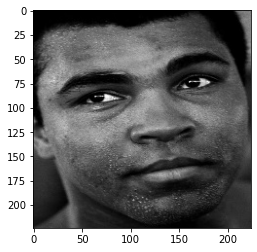

In [32]:
from PIL import Image
image_url = "data_effnet/test/savory/021.jpg"

img = Image.open(image_url).resize((300,300))
img = np.array(img)

pred = model.predict(img[None, :, :])[0]
index = np.argmax(pred)

print(class_names[index],class_indices[index])

plt.imshow(Image.open(image_url))
plt.show()